## Assignment 3 - Stock Price Prediction with RNNs

I have pulled out a lot of the code into python files to reduce the clutter.  You will find all the preprocessing steps, and plotting functions in the utils.py file. In the baseline.py file you will find the training and evaluation code, and in the models.py you will find the ARIMA, RNN, LSTM, GRU. I did try my bes to not plot everything in order to reduce the length of the notebook. Thank you. 

In [1]:
import pandas as pd
from torch import Tensor
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import math
import seaborn as sns
sns.set_theme()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
import os

python_files = "/content/drive/My Drive/pya3"
sys.path.append(os.path.abspath(python_files))

In [4]:
from utils import *
from baseline import *
from models import *

In [5]:
!pip install -q kaggle


In [6]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anguswilliamson","key":"378b7c469a031468201780a10b8d24d2"}'}

In [7]:
!mkdir ~/.kaggle




In [8]:
! cp kaggle.json ~/.kaggle/



In [9]:
! chmod 600 ~/.kaggle/kaggle.json

In [10]:



! kaggle datasets download jacksoncrow/stock-market-dataset


 99% 519M/522M [00:23<00:00, 24.7MB/s]
100% 522M/522M [00:23<00:00, 23.6MB/s]


In [ ]:
! unzip stock-market-dataset.zip 

## Experiment 1 (Many-To-One)

In this exeriment I will compare ARIMA, Vanilla RNN, LSTM, and GRU with the following designs:
  - Targets: (Close)
  - Sequence Length: I will attempt to implement a sequence length that matches the number of lags in the ARIMA model. 

In [12]:
#these will be the datasets sued in the experiments
df_abc = pd.read_csv('stocks/ABC.csv', index_col=0, parse_dates=True)
df_google = pd.read_csv('stocks/GOOGL.csv', index_col=0, parse_dates=True)
df_microsoft = pd.read_csv('stocks/MSFT.csv', index_col=0, parse_dates=True)
df_amazon = pd.read_csv('stocks/AMZN.csv', index_col=0, parse_dates=True)
df_twitter = pd.read_csv('stocks/TWTR.csv', index_col=0, parse_dates=True)
df_tesla = pd.read_csv('stocks/TSLA.csv', index_col=0, parse_dates=True)
df_meta= pd.read_csv('stocks/FB.csv', index_col=0, parse_dates=True)

### 1.1) Comparing Models on ABC (AmerisourceBergen Corp) Data
(Hilarious, I thought it was the ABC network!)

- I will use data from 2010 to the end of 2016 to predict the entire year of 2017. Close will be the target. 



**ARIMA**

I will try first on a somewhat stationary section of the data to have a look at where ARIMA performs at its best. 

In [13]:
#organise data
train = df_abc.loc['2010-01-01':'2016-12-31']
test = df_abc.loc['2017-01-01':'2017-12-31']


training = train['Close'].values
testing = test['Close'].values



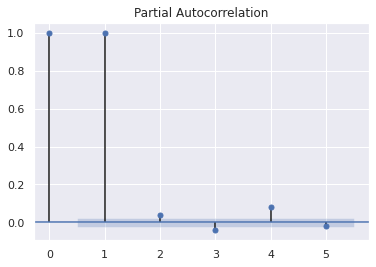

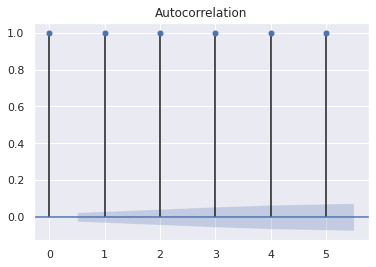

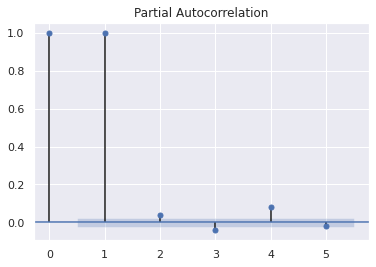

In [14]:
plot_acf(df_abc['Close'], lags=5)
plot_pacf(df_abc['Close'], lags=5)

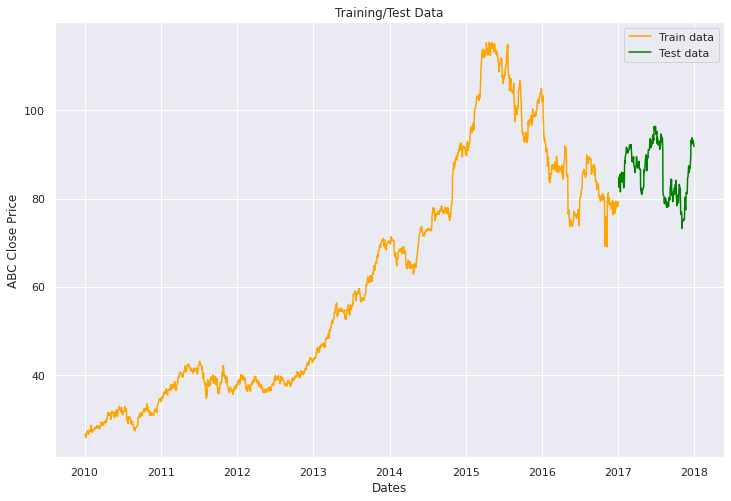

In [15]:
plt.figure(figsize=(12,8))
plt.grid(True)
plt.title('Training/Test Data')
plt.xlabel('Dates')
plt.ylabel(f'ABC Close Price')
plt.plot(train['Close'], 'orange', label='Train data')
plt.plot(test['Close'], 'green', label='Test data')
plt.legend()
plt.show()


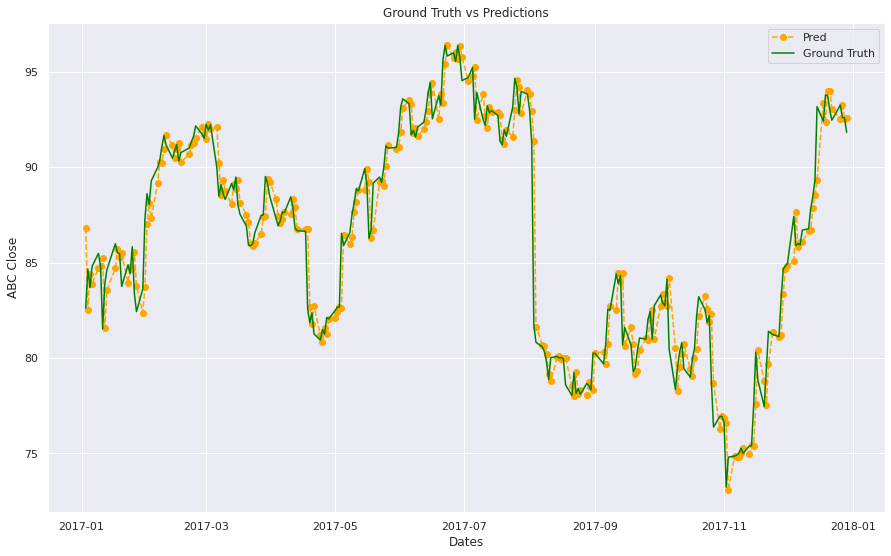

In [16]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

#Arima Model, this function will organise same splits and run model
abc_arima= arima(training,
                testing,
                test,
                order=(5,1,0),
                stock='ABC',
                target='Close',
                )


**Tesla**

Let's see how the ARIMA handles a big upswing that forces it to work over data that is non-stationary. For this, I have selected the Tesla stock as it increased dramatically in price around end of 2019 start of 2020. Normally, this is where we would need to integrate to make the data stationary; however, I would like to see how ARIMA handles this. 

In [17]:
#organise data
trainesla = df_tesla.loc['2018-01-01':'2019-12-31']
testla = df_tesla.loc['2020-01-01':'2020-06-30']

train_tes = trainesla['Close'].values
test_tes = testla['Close'].values


Testing RMSE: 1.386


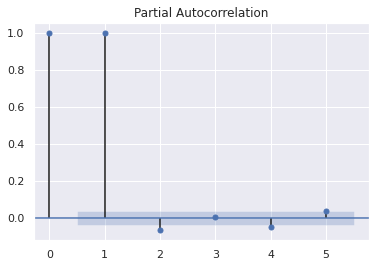

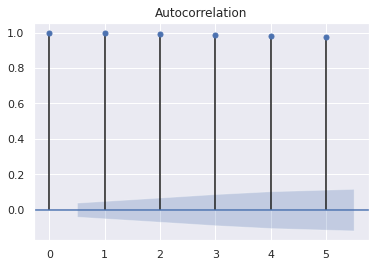

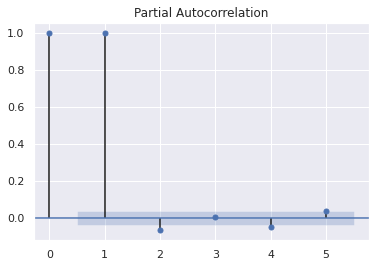

In [18]:
plot_acf(df_tesla['Close'], lags=5)
plot_pacf(df_tesla['Close'], lags=5)

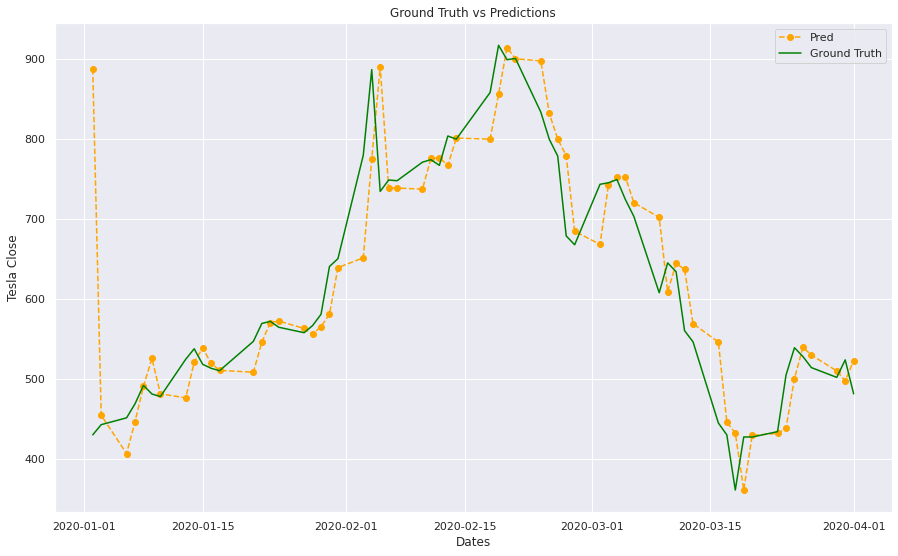

Testing RMSE: 75.045


In [19]:
tesla_arima = arima(train_tes,
                test_tes,
                testla,
                order=(5,1,0),
                stock='Tesla',
                target='Close',
                )

It is still able to approximate the trend but its RMSE is now 75.045. Hopefully one of the RNN model types can beat this. This is a good example of the need to integrate to make the data stationary.

### 1.2 Recurrent Neural Network Models

**ABC**

- I will start with the ABC stock first. ARIMA ABC Baseline RMSE: 1.386

- Each RNN model in this section will be implemented with diff_testset = True so I can match the testing dates with the ARIMA testing dates.


In [20]:
train_loader, val_loader, test_loader, pred_one_loader, scaler, df1, x_train, sequence  = data_sequence(df_abc,'Close', '2010-01-01','2016-12-31',
                                '2017-01-31','2017-12-31', ['Open', 'Low', 'High', 'Adj Close', 'Volume'], 
                                 6, 64, include_target=False, diff_testset=True)

X_train.shape = (1404, 5, 1)
y_train.shape = (1404, 1)
X_validation.shape = (346, 5, 1)
y_validation.shape = (346, 1)
X_test.shape = (226, 5, 1)
y_test.shape = (226, 1)


**Vanilla RNN**

I've tried to use the same lag as the ARIMA model so I have used sequences of 5 to predict the 6th in a sliding window. 

In [21]:
device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

run_no = 1

In [22]:
rnn1 = RNN(in_dims=1,
         hid_dims=160,
         no_layers=1,
         out_dim=1,
         model_name = 'RNN1',
         model_run_no=run_no, 
         drop_prob=0)

history_rnn1 = fit(rnn1.to(device),
            train_loader,
            val_loader,
            epochs=30,
            lr=.001,
            opt_func='Adam',
            batch_size = 64,
            num_feat=1,
            ROPlateau=False)


Epoch [0], train_loss: 0.0252, val_loss: 0.0070
Epoch [5], train_loss: 0.0229, val_loss: 0.0192
Epoch [10], train_loss: 0.0055, val_loss: 0.0168
Epoch [15], train_loss: 0.0051, val_loss: 0.0008
Epoch [20], train_loss: 0.0006, val_loss: 0.0005
Epoch [25], train_loss: 0.0004, val_loss: 0.0005
Training Duration: 0.04 minutes.


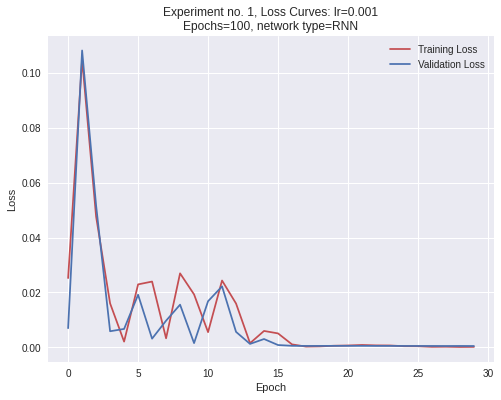

In [23]:
loss_curves(history_rnn1, 
            experiment_no=run_no, 
            lr='0.001', 
            epochs=100, 
            network='RNN')

In [24]:
rnn_1, loss_rnn1 = result(
    rnn1,
    scaler,
    sequence,
    rnn1.model_name,
    rnn1.model_run_no,
    test_loader,
    df1,
    x_train,
    batch_size=64,
    num_feat=1,
    diff_testset=True,)




Test RMSE: 1.888


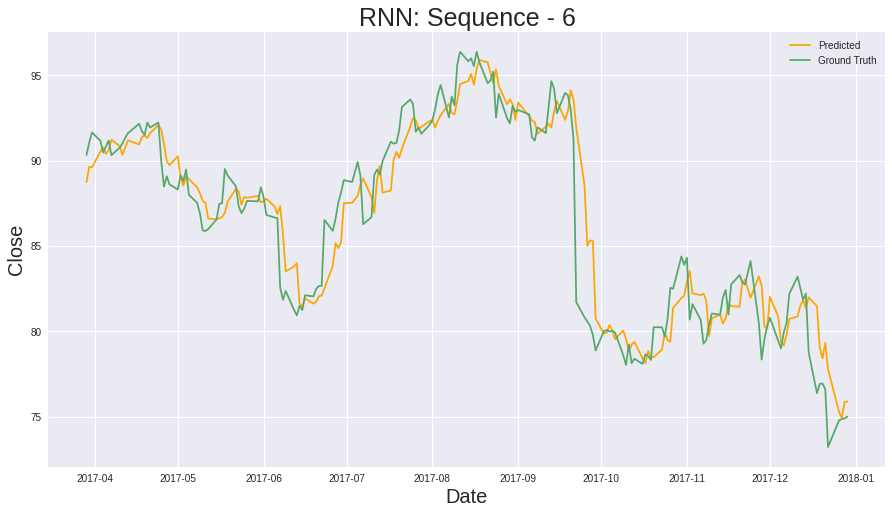

In [25]:
plot_results(rnn_1, 'ABC', 'Close', 'RNN', sequence)

**LSTM**

Understandably, the LSTM is going to be able to extend to much larger sequences; however, I want to see if it can beat arima with the same window.

In [26]:

device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

run_no +=1

In [27]:
lstm1 = LSTM(in_dims=1,
         hid_dims=160,
         no_layers=1,
         out_dim=1,
         model_name = 'LSTM1',
         model_run_no=run_no, 
         drop_prob=0)

history_lstm1 = fit(lstm1.to(device),
            train_loader,
            val_loader,
            epochs=30,
            lr=.001,
            opt_func='Adam',
            batch_size = 64,
            num_feat=1,
            ROPlateau=False)

Epoch [0], train_loss: 0.0293, val_loss: 0.0317
Epoch [5], train_loss: 0.0051, val_loss: 0.0081
Epoch [10], train_loss: 0.0050, val_loss: 0.0014
Epoch [15], train_loss: 0.0023, val_loss: 0.0014
Epoch [20], train_loss: 0.0007, val_loss: 0.0018
Epoch [25], train_loss: 0.0001, val_loss: 0.0009
Training Duration: 0.04 minutes.


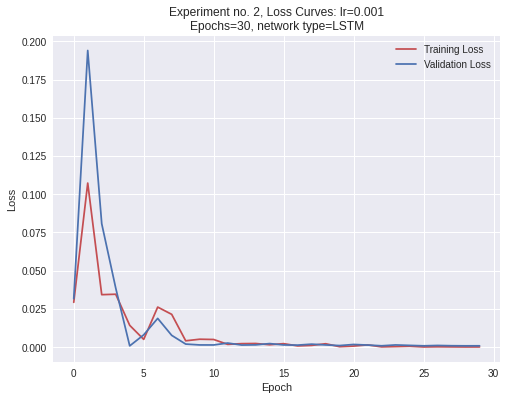

In [28]:
loss_curves(history_lstm1, 
            experiment_no=run_no, 
            lr='0.001', 
            epochs=30, 
            network='LSTM')


In [29]:
lstm1_1, loss_lstm1 = result(
    lstm1,
    scaler,
    sequence,
    lstm1.model_name,
    lstm1.model_run_no,
    test_loader,
    df1,
    x_train,
    batch_size=64,
    num_feat=1,
    diff_testset=True,
)



Test RMSE: 2.569


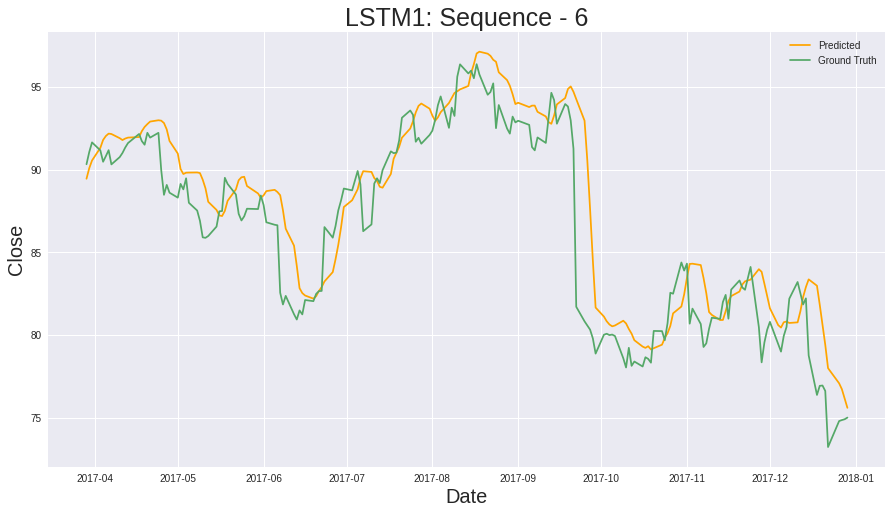

In [30]:
plot_results(lstm1_1, 'ABC', 'Close', 'LSTM1', sequence)

**GRU**

In [31]:
device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

run_no += 1

In [32]:
gru1 = GRU(in_dims=1,
         hid_dims=64,
         no_layers=1,
         out_dim=1,
         model_run_no=run_no,
         drop_prob=0)

history_gru1 = fit(gru1.to(device),
            train_loader,
            val_loader,
            epochs=30,
            lr=.01,
            opt_func='Adam',
            batch_size = 64,
            num_feat=1,
            ROPlateau=False)


Epoch [0], train_loss: 0.0127, val_loss: 0.1844
Epoch [5], train_loss: 0.0178, val_loss: 0.0049
Epoch [10], train_loss: 0.0061, val_loss: 0.0005
Epoch [15], train_loss: 0.0003, val_loss: 0.0004
Epoch [20], train_loss: 0.0001, val_loss: 0.0005
Epoch [25], train_loss: 0.0001, val_loss: 0.0004
Training Duration: 0.03 minutes.


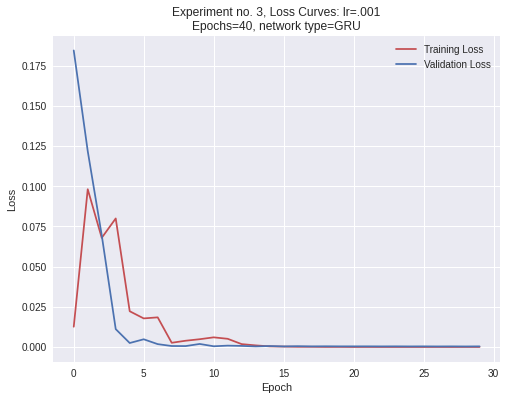

In [33]:

loss_curves(history_gru1, 
            experiment_no=run_no, 
            lr='.001', 
            epochs=40, 
            network='GRU')

In [34]:
gru_1, loss_gru1 = result(
    gru1,
    scaler,
    sequence,
    gru1.model_name,
    gru1.model_run_no,
    test_loader,
    df1,
    x_train,
    batch_size=64,
    num_feat=1,
    diff_testset=True,
)


Test RMSE: 1.813


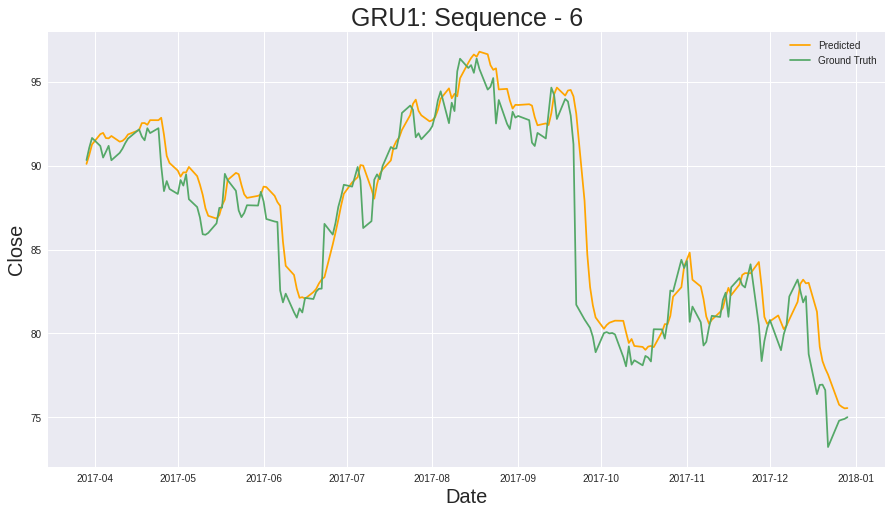

In [35]:
plot_results(gru_1, 'ABC', 'Close', 'GRU1', sequence)

**Tesla Stock**

ARIMA BASELINE RMSE: 75

Let's see how our RNNs handle the adversity of covid.

I'll try not to plot every result I get in the final run so that it is a bit easier to read through. For this next run of models, I will be comparing the RMSE only. 

In [36]:
train_loader, val_loader, test_loader, pred_one_loader, scaler, df1, x_train, sequence  = data_sequence(df_tesla,'Close', '2018-01-01','2019-06-30',
                                '2019-06-30','2020-06-30', ['Open', 'Low', 'High', 'Adj Close', 'Volume'], 
                                 6, 64, include_target=False, diff_testset=True)

X_train.shape = (294, 5, 1)
y_train.shape = (294, 1)
X_validation.shape = (69, 5, 1)
y_validation.shape = (69, 1)
X_test.shape = (185, 5, 1)
y_test.shape = (185, 1)


In [37]:
device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

run_no +=1

In [38]:
rnn2 = RNN(in_dims=1,
         hid_dims=512,
         no_layers=1,
         out_dim=1,
         model_name = 'RNN2',
         model_run_no=run_no, 
         drop_prob=0)

history_rnn2 = fit(rnn2.to(device),
            train_loader,
            val_loader,
            epochs=60,
            lr=.001,
            opt_func='Adam',
            batch_size = 64,
            num_feat=1,
            ROPlateau=False)

Epoch [0], train_loss: 0.1483, val_loss: 0.3193
Epoch [5], train_loss: 0.0196, val_loss: 0.0640
Epoch [10], train_loss: 0.0137, val_loss: 0.0188
Epoch [15], train_loss: 0.0119, val_loss: 0.0106
Epoch [20], train_loss: 0.0110, val_loss: 0.0109
Epoch [25], train_loss: 0.0104, val_loss: 0.0100
Epoch [30], train_loss: 0.0098, val_loss: 0.0096
Epoch [35], train_loss: 0.0094, val_loss: 0.0090
Epoch [40], train_loss: 0.0091, val_loss: 0.0086
Epoch [45], train_loss: 0.0088, val_loss: 0.0082
Epoch [50], train_loss: 0.0086, val_loss: 0.0079
Epoch [55], train_loss: 0.0084, val_loss: 0.0077
Training Duration: 0.01 minutes.


In [39]:
rnn_2, loss_rnn2 = result(
    rnn2,
    scaler,
    sequence,
    rnn2.model_name,
    rnn2.model_run_no,
    test_loader,
    df1,
    x_train,
    batch_size=64,
    num_feat=1,
    diff_testset=True
    )


Test RMSE: 12.924


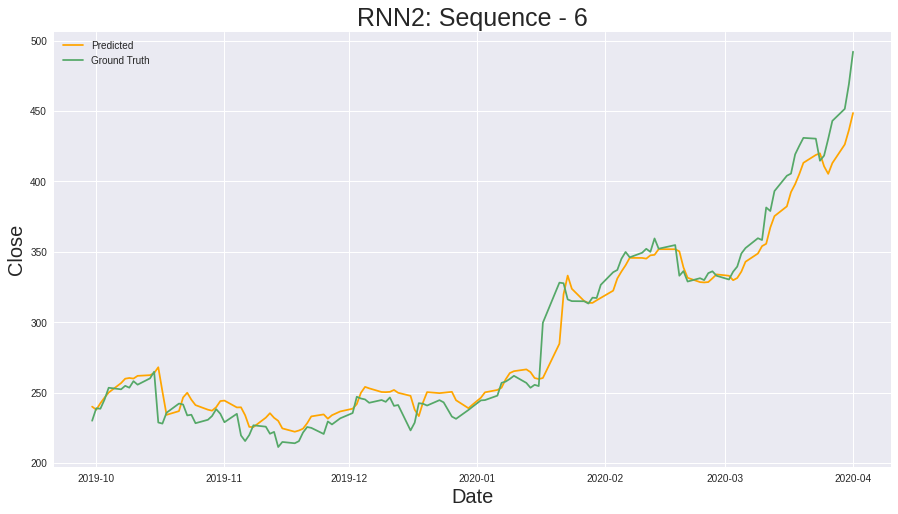

In [40]:
plot_results(rnn_2, 'Tesla', 'Close', 'RNN2', sequence)

**LSTM**

In [41]:
device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

run_no +=1

In [42]:
lstm2 = LSTM(in_dims=1,
         hid_dims=256,
         no_layers=1,
         out_dim=1,
         model_name = 'LSTM2',
         model_run_no=run_no, 
         drop_prob=0)

history_lstm2 = fit(lstm2.to(device),
            train_loader,
            val_loader,
            epochs=50,
            lr=.01,
            opt_func='Adam',
            batch_size = 64,
            num_feat=1,
            ROPlateau=True)




Epoch [0], train_loss: 0.4805, val_loss: 0.0730
Epoch [5], train_loss: 0.0596, val_loss: 0.1732
Epoch [10], train_loss: 0.0340, val_loss: 0.1793
Epoch [15], train_loss: 0.0171, val_loss: 0.0549
Epoch [20], train_loss: 0.0148, val_loss: 0.0446
Epoch [25], train_loss: 0.0133, val_loss: 0.0440
Epoch [30], train_loss: 0.0120, val_loss: 0.0407
Epoch [35], train_loss: 0.0115, val_loss: 0.0337
Epoch [40], train_loss: 0.0100, val_loss: 0.0334
Epoch [45], train_loss: 0.0093, val_loss: 0.0317
Training Duration: 0.01 minutes.


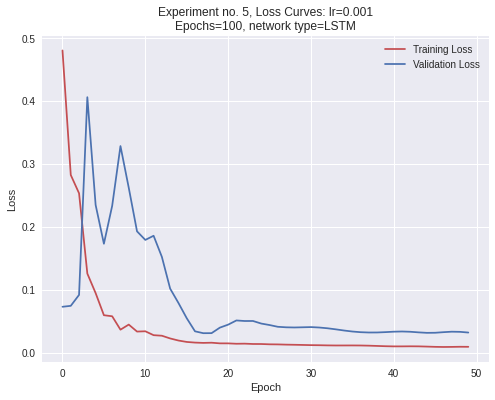

In [43]:
loss_curves(history_lstm2, 
            experiment_no=run_no, 
            lr='0.001', 
            epochs=100, 
            network='LSTM')

In [44]:
lstm2_2, loss_lstm2 = result(
    lstm2,
    scaler,
    sequence,
    lstm2.model_name,
    lstm2.model_run_no,
    test_loader,
    df1,
    x_train,
    batch_size=64,
    num_feat=1,
    diff_testset=True,
)

Test RMSE: 18.011


**GRU TESLA**

In [45]:
device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

run_no +=1

In [46]:
gru2 = GRU(in_dims=1,
         hid_dims=512,
         no_layers=1,
         out_dim=1,
         model_run_no=run_no,
         drop_prob=0)

history_gru2 = fit(gru2.to(device),
            train_loader,
            val_loader,
            epochs=90,
            lr=.01,
            opt_func='Adam',
            batch_size = 64,
            num_feat=1,
            ROPlateau=False)


Epoch [0], train_loss: 0.2917, val_loss: 0.1423
Epoch [5], train_loss: 0.0500, val_loss: 0.1729
Epoch [10], train_loss: 0.0233, val_loss: 0.1734
Epoch [15], train_loss: 0.0151, val_loss: 0.0559
Epoch [20], train_loss: 0.0109, val_loss: 0.0100
Epoch [25], train_loss: 0.0099, val_loss: 0.0156
Epoch [30], train_loss: 0.0091, val_loss: 0.0205
Epoch [35], train_loss: 0.0085, val_loss: 0.0215
Epoch [40], train_loss: 0.0081, val_loss: 0.0233
Epoch [45], train_loss: 0.0078, val_loss: 0.0222
Epoch [50], train_loss: 0.0077, val_loss: 0.0205
Epoch [55], train_loss: 0.0076, val_loss: 0.0186
Epoch [60], train_loss: 0.0076, val_loss: 0.0169
Epoch [65], train_loss: 0.0076, val_loss: 0.0157
Epoch [70], train_loss: 0.0075, val_loss: 0.0151
Epoch [75], train_loss: 0.0075, val_loss: 0.0149
Epoch [80], train_loss: 0.0075, val_loss: 0.0148
Epoch [85], train_loss: 0.0075, val_loss: 0.0148
Training Duration: 0.02 minutes.


In [47]:
gru_2, loss_gru2 = result(
    gru2,
    scaler,
    sequence,
    gru2.model_name,
    gru2.model_run_no,
    test_loader,
    df1,
    x_train,
    batch_size=64,
    num_feat=1,
    diff_testset=True,
)

Test RMSE: 12.401


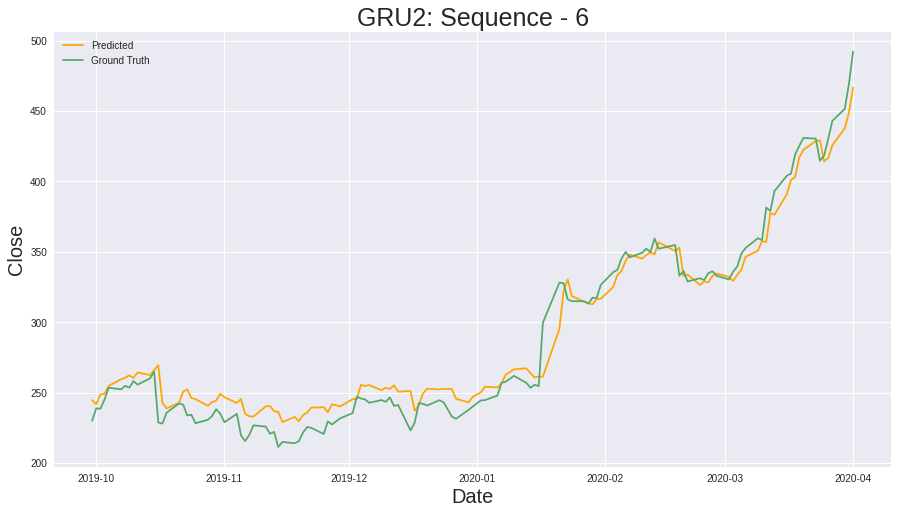

In [48]:
plot_results(gru_2, 'Tesla', 'Close', 'GRU2', sequence)

## Experiment 2 (Many to One)

In this exeriment I will explore a range of sequences lengths on Vanilla RNN, LSTM, and GRU. The main experiment here is not to use the best hyperparameters but to see how each model handles the respective sequence lengths. I will try and only display the best result for each model set. I'm hoping to see if using truncated back propagation helps alleviate some of the vanishing/exploding gradient problems

### 2.1 Vanilla RNNs 

Predicting Google Closing Price

Sequences: I will try to keep the RNN ones manageable.

- model 1: sequence 30
- model 2: sequence 60
- model 3: sequence 100

In [49]:
train_loader, val_loader, test_loader, pred_one_loader, scaler, df1, x_train, sequence  = data_sequence(df_google,'Close', '2010-01-01','2018-01-01',
                                '2013-01-02','2018-01-01', ['Adj Close', 'Volume', 'Open', 'Low', 'High'], 
                                 30, 32, include_target=True, diff_testset=False)

X_train.shape = (1177, 29, 1)
y_train.shape = (1177, 1)
X_validation.shape = (373, 29, 1)
y_validation.shape = (373, 1)
X_test.shape = (373, 29, 1)
y_test.shape = (373, 1)


**Vanilla RNN (Sequence 30)**

In [50]:
device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

run_no +=1

In [51]:
#adjust in_dims
rnn3 = RNN(in_dims=1,
         hid_dims=1024,
         no_layers=1,
         out_dim=1,
         model_name = 'RNN3',
         model_run_no=run_no, 
         drop_prob=0)

#adjust num_feat
history_rnn3 = fit(rnn3.to(device),
            train_loader,
            val_loader,
            epochs=60,
            lr=.0001,
            opt_func='Adam',
            batch_size = 32,
            num_feat=1,
            ROPlateau=False)


Epoch [0], train_loss: 0.0100, val_loss: 0.0424
Epoch [5], train_loss: 0.0272, val_loss: 0.0321
Epoch [10], train_loss: 0.0026, val_loss: 0.0021
Epoch [15], train_loss: 0.0045, val_loss: 0.0034
Epoch [20], train_loss: 0.0036, val_loss: 0.0029
Epoch [25], train_loss: 0.0030, val_loss: 0.0024
Epoch [30], train_loss: 0.0029, val_loss: 0.0024
Epoch [35], train_loss: 0.0025, val_loss: 0.0022
Epoch [40], train_loss: 0.0017, val_loss: 0.0018
Epoch [45], train_loss: 0.0022, val_loss: 0.0018
Epoch [50], train_loss: 0.0022, val_loss: 0.0017
Epoch [55], train_loss: 0.0017, val_loss: 0.0017
Training Duration: 0.16 minutes.


In [52]:
rnn_3, loss_rnn3 = result(
    rnn3,
    scaler,
    sequence,
    rnn3.model_name,
    rnn3.model_run_no,
    test_loader,
    df1,
    x_train,
    batch_size=32,
    num_feat=1,
    diff_testset=False,
   )


Test RMSE: 31.709


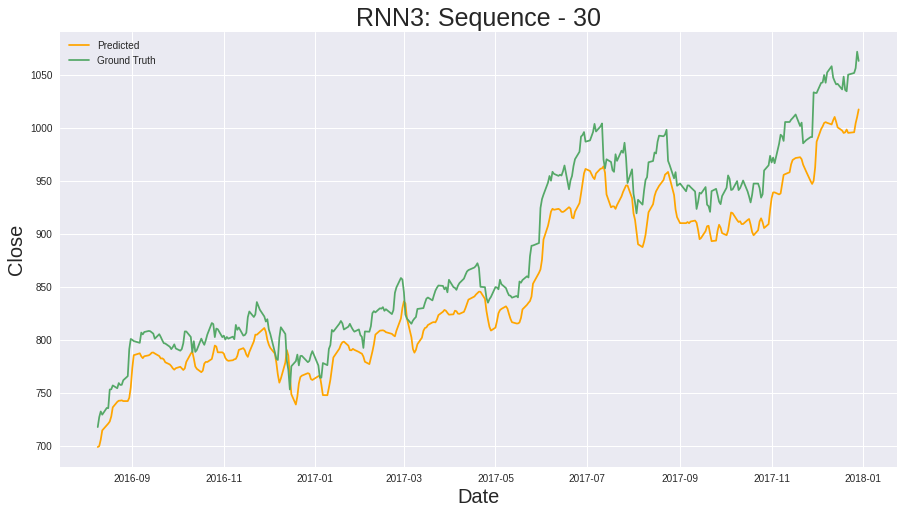

In [53]:
plot_results(rnn_3, 'Google', 'Close', 'RNN3', sequence)

**RNN (Sequence 60)**

In [54]:
train_loader, val_loader, test_loader, pred_one_loader, scaler, df1, x_train, sequence  = data_sequence(df_google,'Close', '2010-01-01','2018-01-01',
                                '','', ['Adj Close', 'Volume', 'Open', 'Low', 'High'], 
                                 60, 16, include_target=True, diff_testset=False)

X_train.shape = (1147, 59, 1)
y_train.shape = (1147, 1)
X_validation.shape = (343, 59, 1)
y_validation.shape = (343, 1)
X_test.shape = (343, 59, 1)
y_test.shape = (343, 1)


In [55]:
device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

run_no +=1

In [56]:
#adjust in_dims
rnn4 = RNN(in_dims=1,
         hid_dims=1024,
         no_layers=1,
         out_dim=1,
         model_name = 'RNN4',
         model_run_no=run_no, 
         drop_prob=0.0)

#adjust num_feat
history_rnn4 = fit(rnn4.to(device),
            train_loader,
            val_loader,
            epochs=30,
            lr=.0001,
            opt_func='Adam',
            batch_size = 16,
            num_feat=1,
            ROPlateau=False)

Epoch [0], train_loss: 0.0072, val_loss: 0.0237
Epoch [5], train_loss: 0.1756, val_loss: 0.1047
Epoch [10], train_loss: 0.0012, val_loss: 0.0033
Epoch [15], train_loss: 0.0006, val_loss: 0.0031
Epoch [20], train_loss: 0.0006, val_loss: 0.0030
Epoch [25], train_loss: 0.0006, val_loss: 0.0030
Training Duration: 0.23 minutes.


In [57]:
rnn_4, loss_rnn4 = result(
    rnn4,
    scaler,
    sequence,
    rnn4.model_name,
    rnn4.model_run_no,
    test_loader,
    df1,
    x_train,
    batch_size=16,
    num_feat=1,
    diff_testset=False,
 )


Test RMSE: 37.097


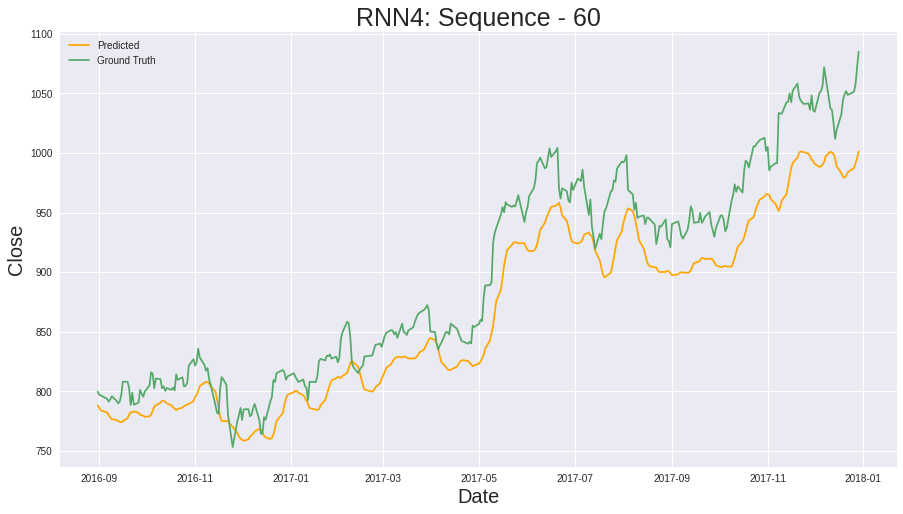

In [58]:
plot_results(rnn_4, 'Google', 'Close', 'RNN4', sequence)

**Sequence 100**

Trying to use smaller batches so there is more control over gradient updates. Additionally, I'll run for less epochs. I will however use the full dataset to account for the longer sequence. I'll set dates to empty to access full dataset. 

In [54]:
train_loader, val_loader, test_loader, pred_one_loader, scaler, df1, x_train, sequence  = data_sequence(df_google,'Close', 'Empty','Empty',
                                '','', ['Adj Close', 'Volume', 'Open', 'Low', 'High'], 
                                 100, 16, include_target=True, diff_testset=False)

X_train.shape = (2260, 99, 1)
y_train.shape = (2260, 1)
X_validation.shape = (686, 99, 1)
y_validation.shape = (686, 1)
X_test.shape = (686, 99, 1)
y_test.shape = (686, 1)


In [55]:
device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)
run_no +=1

In [56]:
#adjust in_dims
rnn5 = RNN(in_dims=1,
         hid_dims=1024,
         no_layers=1,
         out_dim=1,
         model_name = 'RNN5',
         model_run_no=run_no, 
         drop_prob=0.0)


history_rnn5 = fit(rnn5.to(device),
            train_loader,
            val_loader,
            epochs=20,
            lr=.0001,
            opt_func='Adam',
            batch_size = 16,
            num_feat=1,
            ROPlateau=False)

Epoch [0], train_loss: 0.0063, val_loss: 0.0460
Epoch [5], train_loss: 0.0083, val_loss: 0.0129
Epoch [10], train_loss: 0.0002, val_loss: 0.0011
Epoch [15], train_loss: 0.0002, val_loss: 0.0009
Training Duration: 0.49 minutes.


In [57]:
rnn_5, loss_rnn5 = result(
    rnn5,
    scaler,
    sequence,
    rnn5.model_name,
    rnn5.model_run_no,
    test_loader,
    df1,
    x_train,
    batch_size=16,
    num_feat=1,
    diff_testset=False,
)


Test RMSE: 56.793


Performance for vanilla RNN has certainly dropped at larger sequence length.

### 2.2 LSTM

Sequences:

- 30 

- 100

- 500



**30**

In [73]:
train_loader, val_loader, test_loader, pred_one_loader, scaler, df1, x_train, sequence  = data_sequence(df_google,'Close', '2010-01-01','2018-01-01',
                                '','', ['Adj Close', 'Volume', 'Open', 'Low', 'High'], 
                                 30, 64, include_target=True, diff_testset=False)

X_train.shape = (1177, 29, 1)
y_train.shape = (1177, 1)
X_validation.shape = (373, 29, 1)
y_validation.shape = (373, 1)
X_test.shape = (373, 29, 1)
y_test.shape = (373, 1)


In [74]:
device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)
run_no +=1

In [75]:
#adjust in_dims
lstm3 = LSTM(in_dims=1,
         hid_dims=512,
         no_layers=1,
         out_dim=1,
         model_name = 'LSTM3',
         model_run_no=run_no, 
         drop_prob=0)

#adjust num_feat
history_lstm3 = fit(lstm3.to(device),
            train_loader,
            val_loader,
            epochs=50,
            lr=.001,
            opt_func='Adam',
            batch_size = 64,
            num_feat=1,
            ROPlateau=False)


Epoch [0], train_loss: 0.0426, val_loss: 0.1464
Epoch [5], train_loss: 0.0657, val_loss: 0.1985
Epoch [10], train_loss: 0.0131, val_loss: 2.1486
Epoch [15], train_loss: 0.0147, val_loss: 0.0143
Epoch [20], train_loss: 0.0034, val_loss: 0.0022
Epoch [25], train_loss: 0.0026, val_loss: 0.0023
Epoch [30], train_loss: 0.0018, val_loss: 0.0031
Epoch [35], train_loss: 0.0007, val_loss: 0.0022
Epoch [40], train_loss: 0.0012, val_loss: 0.0023
Epoch [45], train_loss: 0.0008, val_loss: 0.0019
Training Duration: 0.10 minutes.


In [76]:
lstm_3, loss_lstm3 = result(
    lstm3,
    scaler,
    sequence,
    lstm3.model_name,
    lstm3.model_run_no,
    test_loader,
    df1,
    x_train,
    batch_size=64,
    num_feat=1,
    diff_testset=False,
  )


Test RMSE: 19.73


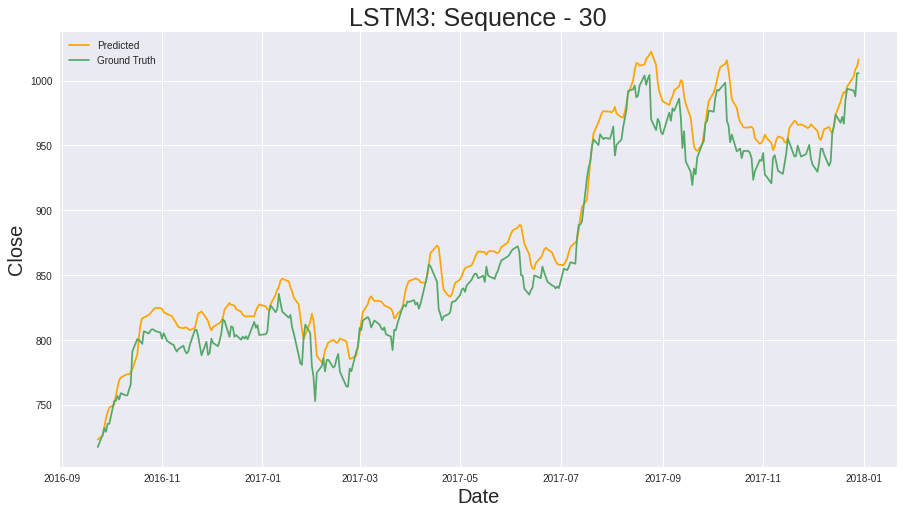

In [143]:
plot_results(lstm_3, 'Google', 'Close', 'LSTM3', 30)

**100**

See if LSTM is able to handle a larger batch size than Vanilla RNN


In [77]:
train_loader, val_loader, test_loader, pred_one_loader, scaler, df1, x_train, sequence  = data_sequence(df_google,'Close', '2004-01-01','2018-01-01',
                                '','', ['Adj Close', 'Volume', 'Open', 'Low', 'High'], 
                                 100, 64, include_target=True, diff_testset=False)

X_train.shape = (1920, 99, 1)
y_train.shape = (1920, 1)
X_validation.shape = (573, 99, 1)
y_validation.shape = (573, 1)
X_test.shape = (573, 99, 1)
y_test.shape = (573, 1)


In [78]:
device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)
run_no +=1

In [79]:
lstm4 = LSTM(in_dims=1,
         hid_dims=512,
         no_layers=1,
         out_dim=1,
         model_name = 'LSTM4',
         model_run_no=run_no, 
         drop_prob=0)

history_lstm4 = fit(lstm4.to(device),
            train_loader,
            val_loader,
            epochs=20,
            lr=.001,
            opt_func='Adam',
            batch_size = 64,
            num_feat=1,
            ROPlateau=False)


Epoch [0], train_loss: 0.0513, val_loss: 0.2333
Epoch [5], train_loss: 0.0215, val_loss: 0.1044
Epoch [10], train_loss: 0.0015, val_loss: 0.0096
Epoch [15], train_loss: 0.0007, val_loss: 0.0106
Training Duration: 0.22 minutes.


In [80]:
lstm_4, loss_lstm4 = result(
    lstm4,
    scaler,
    sequence,
    lstm4.model_name,
    lstm4.model_run_no,
    test_loader,
    df1,
    x_train,
    batch_size=64,
    num_feat=1,
    diff_testset=False,
  )

Test RMSE: 50.647


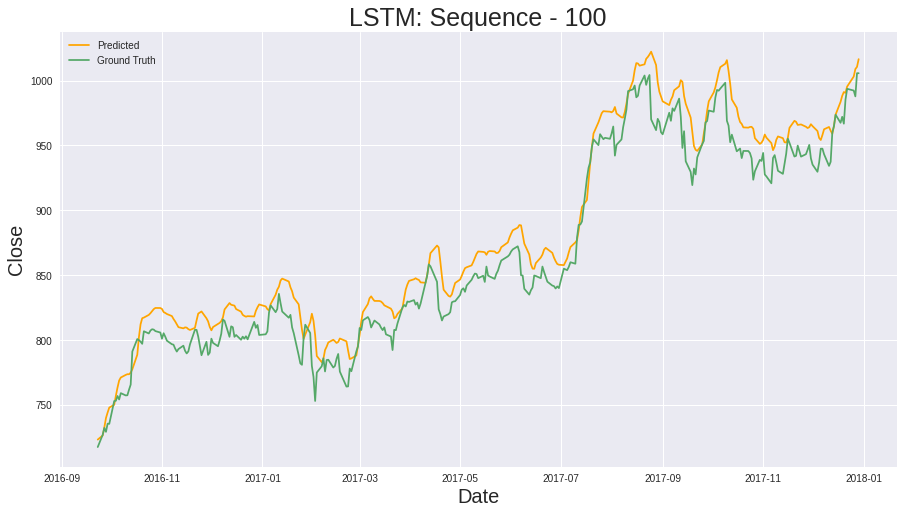

In [81]:
plot_results(lstm_3, 'Google', 'Close', 'LSTM', sequence)

**500**

Going to use full dataset for this test. Will input dates as 'Empty' to access full data as I can't implement sequences of 300 with a short length dataset. I will return to batch sizes of 16 to handle the large sequence.

In [82]:
train_loader, val_loader, test_loader, pred_one_loader, scaler, df1, x_train, sequence  = data_sequence(df_google,'Close', 'Empty','Empty',
                                '','', ['Adj Close', 'Volume', 'Open', 'Low', 'High'], 
                                 500, 16, include_target=True, diff_testset=False)

X_train.shape = (1860, 499, 1)
y_train.shape = (1860, 1)
X_validation.shape = (286, 499, 1)
y_validation.shape = (286, 1)
X_test.shape = (286, 499, 1)
y_test.shape = (286, 1)


In [83]:
device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)
run_no +=1

In [84]:

lstm5 = LSTM(in_dims=1,
         hid_dims=256,
         no_layers=1,
         out_dim=1,
         model_name = 'LSTM5',
         model_run_no=run_no, 
         drop_prob=0)


history_lstm5 = fit(lstm5.to(device),
            train_loader,
            val_loader,
            epochs=20,
            lr=.001,
            opt_func='Adam',
            batch_size = 16,
            num_feat=1,
            ROPlateau=False)

Epoch [0], train_loss: 0.0085, val_loss: 0.1168
Epoch [5], train_loss: 0.0092, val_loss: 0.0697
Epoch [10], train_loss: 0.0062, val_loss: 0.0332
Epoch [15], train_loss: 0.0004, val_loss: 0.0007
Training Duration: 0.75 minutes.


In [85]:
lstm_5, loss_lstm5 = result(
    lstm5,
    scaler,
    sequence,
    lstm5.model_name,
    lstm5.model_run_no,
    test_loader,
    df1,
    x_train,
    batch_size=16,
    num_feat=1,
    diff_testset=False)

Test RMSE: 25.763


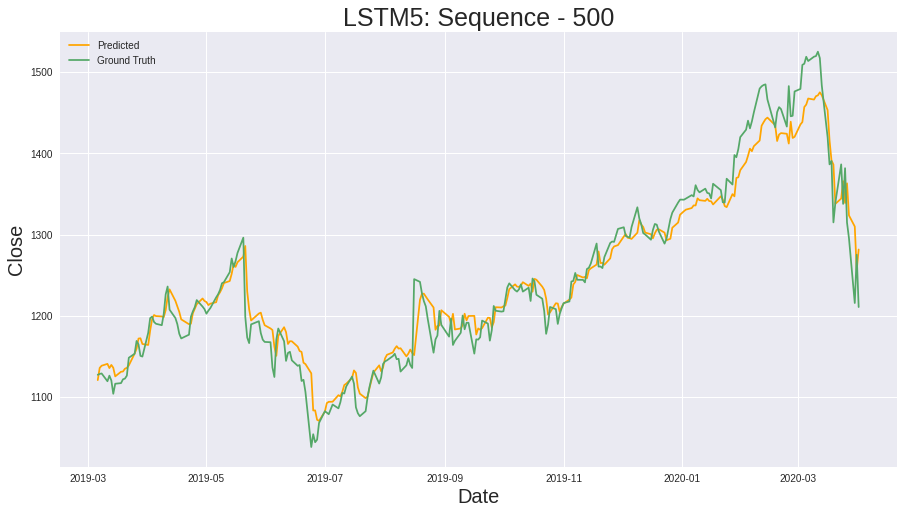

In [86]:
plot_results(lstm_5, 'Google', 'Close', 'LSTM5', sequence)

### 2.3 Gru

Sequences

- 30
- 100
- 500


**30**

In [87]:
train_loader, val_loader, test_loader, pred_one_loader, scaler, df1, x_train, sequence  = data_sequence(df_google,'Close', '2010-01-01','2018-01-01',
                                '','', ['Adj Close', 'Volume', 'Open', 'Low', 'High'], 
                                 30, 64, include_target=True, diff_testset=False)

X_train.shape = (1177, 29, 1)
y_train.shape = (1177, 1)
X_validation.shape = (373, 29, 1)
y_validation.shape = (373, 1)
X_test.shape = (373, 29, 1)
y_test.shape = (373, 1)


In [88]:
device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

run_no +=1

In [89]:

gru3 = GRU(in_dims=1,
         hid_dims=512,
         no_layers=1,
         out_dim=1,
         model_name = 'GRU3',
         model_run_no=run_no, 
         drop_prob=0.0)


history_gru3 = fit(gru3.to(device),
            train_loader,
            val_loader,
            epochs=40,
            lr=.001,
            opt_func='Adam',
            batch_size = 64,
            num_feat=1,
            ROPlateau=False)

Epoch [0], train_loss: 0.0074, val_loss: 0.0179
Epoch [5], train_loss: 0.0034, val_loss: 0.0038
Epoch [10], train_loss: 0.0005, val_loss: 0.0020
Epoch [15], train_loss: 0.0004, val_loss: 0.0013
Epoch [20], train_loss: 0.0004, val_loss: 0.0013
Epoch [25], train_loss: 0.0018, val_loss: 0.0012
Epoch [30], train_loss: 0.0006, val_loss: 0.0012
Epoch [35], train_loss: 0.0003, val_loss: 0.0011
Training Duration: 0.07 minutes.


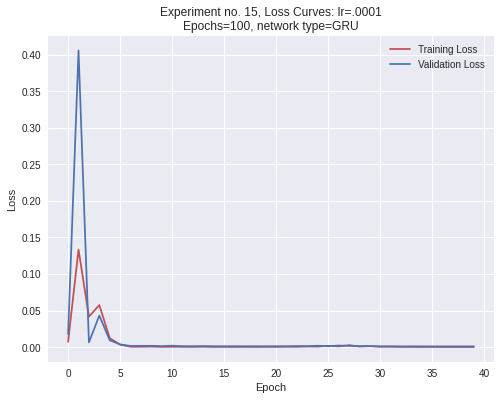

In [90]:
loss_curves(history_gru3, 
            experiment_no=run_no, 
            lr='.0001', 
            epochs=100, 
            network='GRU')

In [91]:
gru_3, loss_gru3 = result(
    gru3,
    scaler,
    sequence,
    gru3.model_name,
    gru3.model_run_no,
    test_loader,
    df1,
    x_train,
    batch_size=64,
    num_feat=1,
    diff_testset=False,
    )

Test RMSE: 14.611


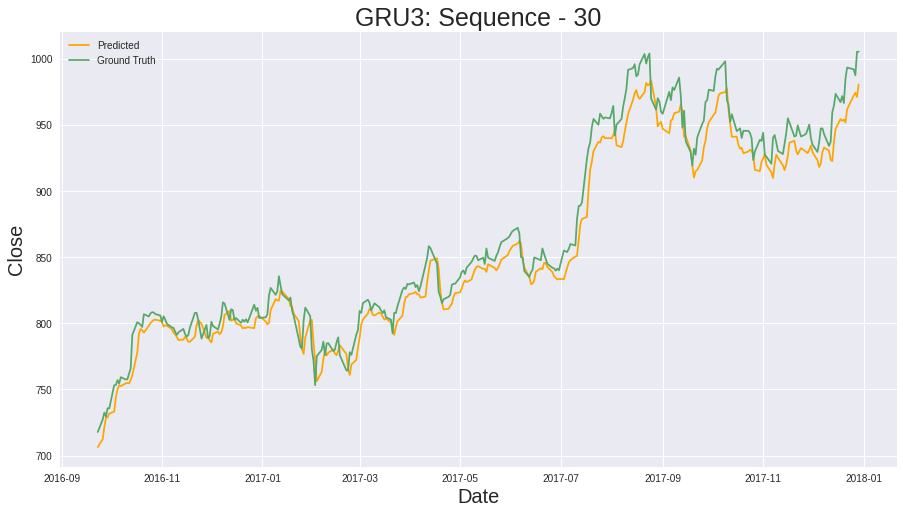

In [92]:
plot_results(gru_3, 'Google', 'Close', 'GRU3', sequence)

**100**

In [93]:
train_loader, val_loader, test_loader, pred_one_loader, scaler, df1, x_train, sequence  = data_sequence(df_google,'Close', '2010-01-01','2018-01-01',
                                '','', ['Adj Close', 'Volume', 'Open', 'Low', 'High'], 
                                 100, 32, include_target=True, diff_testset=False)

X_train.shape = (1107, 99, 1)
y_train.shape = (1107, 1)
X_validation.shape = (303, 99, 1)
y_validation.shape = (303, 1)
X_test.shape = (303, 99, 1)
y_test.shape = (303, 1)


In [94]:
device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

In [95]:

gru4 = GRU(in_dims=1,
         hid_dims=512,
         no_layers=1,
         out_dim=1,
         model_name = 'GRU4',
         model_run_no=run_no, 
         drop_prob=0)


history_gru4 = fit(gru4.to(device),
            train_loader,
            val_loader,
            epochs=30,
            lr=.001,
            opt_func='Adam',
            batch_size = 32,
            num_feat=1,
            ROPlateau=False)

Epoch [0], train_loss: 0.0124, val_loss: 0.0840
Epoch [5], train_loss: 0.0301, val_loss: 0.0072
Epoch [10], train_loss: 0.0003, val_loss: 0.0011
Epoch [15], train_loss: 0.0003, val_loss: 0.0011
Epoch [20], train_loss: 0.0003, val_loss: 0.0011
Epoch [25], train_loss: 0.0002, val_loss: 0.0011
Training Duration: 0.19 minutes.


In [96]:
gru_4, loss_gru4 = result(
    gru4,
    scaler,
    sequence,
    gru4.model_name,
    gru4.model_run_no,
    test_loader,
    df1,
    x_train,
    batch_size=32,
    num_feat=1,
    diff_testset=False,
   )

Test RMSE: 18.866


**500**

Again, using full dataset from 1995-2020 for larger sequence length

In [97]:
train_loader, val_loader, test_loader, pred_one_loader, scaler, df1, x_train, sequence  = data_sequence(df_google,'Close', 'Empty','Empty',
                                '','', ['Adj Close', 'Volume', 'Open', 'Low', 'High'], 
                                 500, 16, include_target=True, diff_testset=False)

X_train.shape = (1860, 499, 1)
y_train.shape = (1860, 1)
X_validation.shape = (286, 499, 1)
y_validation.shape = (286, 1)
X_test.shape = (286, 499, 1)
y_test.shape = (286, 1)


In [98]:
device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

In [99]:
run_no+=1

In [100]:

gru5 = GRU(in_dims=1,
         hid_dims=512,
         no_layers=1,
         out_dim=1,
         model_name = 'GRU5',
         model_run_no=run_no, 
         drop_prob=0)


history_gru5 = fit(gru5.to(device),
            train_loader,
            val_loader,
            epochs=20,
            lr=.0001,
            opt_func='Adam',
            batch_size = 16,
            num_feat=1,
            ROPlateau=False)

Epoch [0], train_loss: 0.0219, val_loss: 0.1195
Epoch [5], train_loss: 0.0057, val_loss: 0.0214
Epoch [10], train_loss: 0.0003, val_loss: 0.0008
Epoch [15], train_loss: 0.0003, val_loss: 0.0007
Training Duration: 1.46 minutes.


In [101]:
gru_5, loss_gru5 = result(
    gru5,
    scaler,
    sequence,
    gru5.model_name,
    gru5.model_run_no,
    test_loader,
    df1,
    x_train,
    batch_size=16,
    num_feat=1,
    diff_testset=False
    )

Test RMSE: 28.132


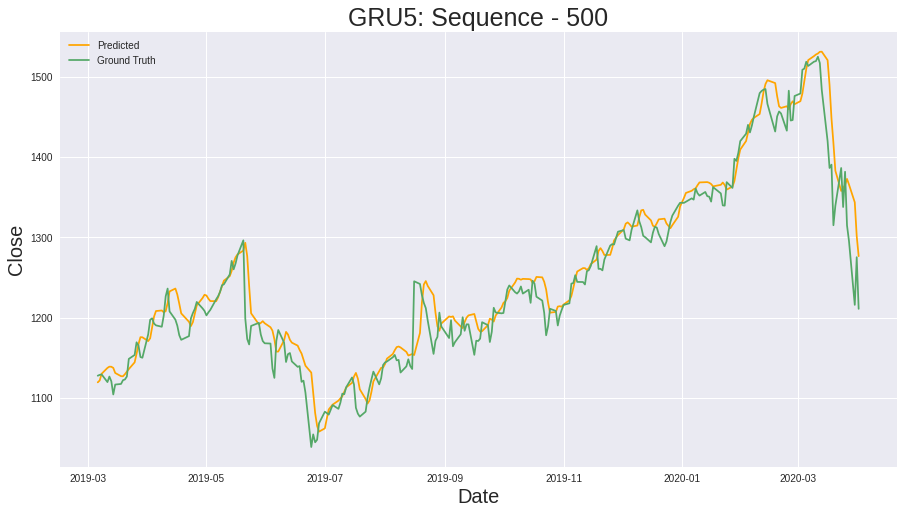

In [102]:
plot_results(gru_5, 'Google', 'Close', 'GRU5', sequence)

## Experiment 3 (Many-to-One)

In this exeriment I will compare LSTM and GRU. I will use the same hyperparameters for each model to provide a more accurate comparison. 
  - Models: (LSTM, GRU)
  - Target: Opening Price
  - Sequence length: 200


The goal is to use a complicated dataset. The Amazon dataset has so far been troublesome so I will use that.

**LSTM**

In [103]:
train_loader, val_loader, test_loader, pred_one_loader, scaler, df1, x_train, sequence  = data_sequence(df_amazon,'Open', ' 2010-01-01','2017-01-01',
                                '2018-01-01','2018-10-01', ['Low', 'Volume', 'Low', 'Close', 'Adj Close','High'], 
                                 200, 16, include_target=True, diff_testset=False)

X_train.shape = (858, 199, 1)
y_train.shape = (858, 1)
X_validation.shape = (152, 199, 1)
y_validation.shape = (152, 1)
X_test.shape = (152, 199, 1)
y_test.shape = (152, 1)


In [104]:
device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

run_no+= 1

In [105]:
lstm6 = LSTM(in_dims=1,
         hid_dims=512,
         no_layers=1,
         out_dim=1,
         model_name = 'lstm6',
         model_run_no=run_no, 
         drop_prob=0.0)


history_lstm6 = fit(lstm6.to(device),
            train_loader,
            val_loader,
            epochs=30,
            lr=.001,
            opt_func='Adam',
            batch_size = 16,
            num_feat=1,
            ROPlateau=False)

Epoch [0], train_loss: 0.0133, val_loss: 0.0417
Epoch [5], train_loss: 0.0391, val_loss: 0.0244
Epoch [10], train_loss: 0.0301, val_loss: 0.0746
Epoch [15], train_loss: 0.0084, val_loss: 0.0041
Epoch [20], train_loss: 0.0003, val_loss: 0.0013
Epoch [25], train_loss: 0.0003, val_loss: 0.0014
Training Duration: 0.56 minutes.


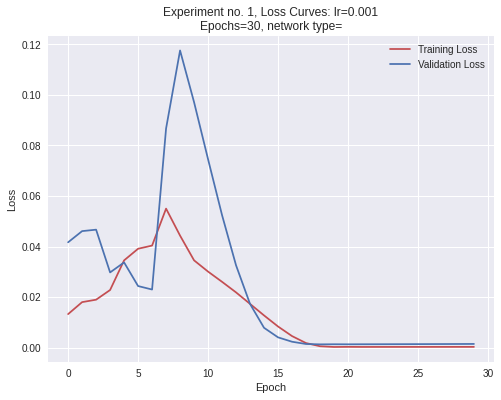

In [106]:
loss_curves(history_lstm6)

In [107]:
lstm_6, loss_lstm6 = result(
    lstm6,
    scaler,
    sequence,
    lstm6.model_name,
    lstm6.model_run_no,
    test_loader,
    df1,
    x_train,
    batch_size=16,
    num_feat=1,
    diff_testset=False)

Test RMSE: 65.524


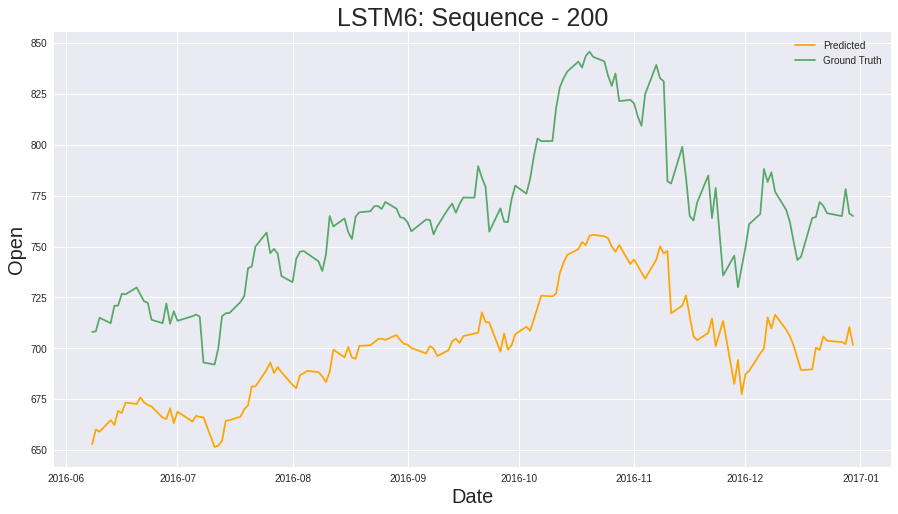

In [108]:
plot_results(lstm_6, 'Amazon', 'Open', 'LSTM6', sequence)

**GRU**

In [109]:
device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

run_no+=1

In [110]:

gru6 = GRU(in_dims=1,
         hid_dims=512,
         no_layers=1,
         out_dim=1,
         model_name = 'GRU6',
         model_run_no=run_no, 
         drop_prob=0)


history_gru6 = fit(gru6.to(device),
            train_loader,
            val_loader,
            epochs=30,
            lr=.001,
            opt_func='Adam',
            batch_size = 16,
            num_feat=1,
            ROPlateau=False)

Epoch [0], train_loss: 0.0114, val_loss: 0.0240
Epoch [5], train_loss: 0.0090, val_loss: 0.0295
Epoch [10], train_loss: 0.0171, val_loss: 0.0127
Epoch [15], train_loss: 0.0048, val_loss: 0.0014
Epoch [20], train_loss: 0.0020, val_loss: 0.0014
Epoch [25], train_loss: 0.0003, val_loss: 0.0013
Training Duration: 0.43 minutes.


In [111]:
gru_6, loss_gru6 = result(
    gru6,
    scaler,
    sequence,
    gru6.model_name,
    gru6.model_run_no,
    test_loader,
    df1,
    x_train,
    batch_size=16,
    num_feat=1,
    diff_testset=False)

Test RMSE: 17.111


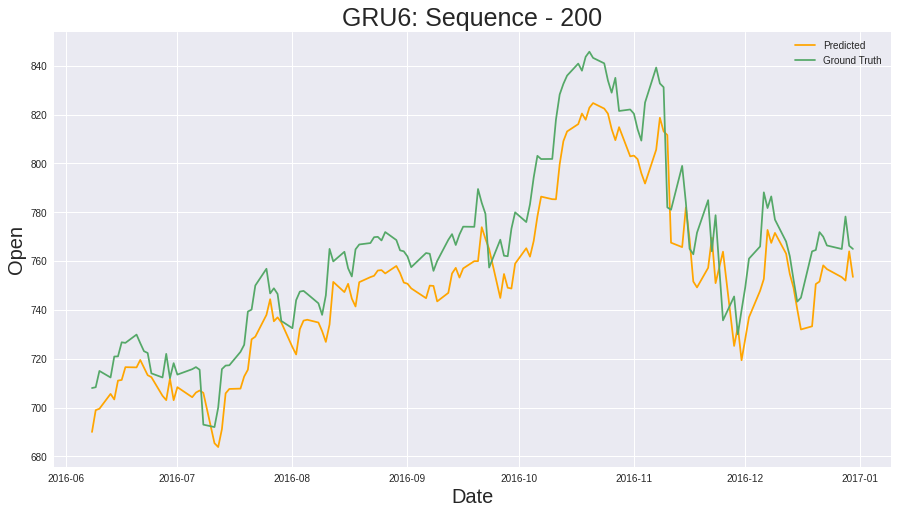

In [112]:
plot_results(gru_6, 'Amazon', 'Open', 'GRU6', sequence)

The GRU has a faster compute time and a lower RMSE on Testing. Therefore, I will use GRU in the final experiment.

## Experiment 4 (Many-to-One)

In this exeriment I will use the best Model from Experiment 3 to explore if the features of other stock prices enable us to predict a single stock price more robustly.
  - Stocks: Netflix, Twitter to predict Meta
  - Targets: (Meta Specific stock feature)
  - Input Dimensions (Feature set): different features from different stocks
  - Sequence Length: Will attempt to use the best sequence length

I will also use a combination of one stocks features to predict a target

### 4.1 Stock Merging

I'll start by using the close price of meta, netflix and twitter to predict the close price of Meta.

In [113]:
def stock_merger(stock1: str,
                 stock2: str,
                 stock3: str):

    df1 = pd.read_csv(f'stocks/{stock1}.csv', index_col=0, parse_dates=True)
    df2 = pd.read_csv(f'stocks/{stock2}.csv', index_col=0, parse_dates=True)
    df3 = pd.read_csv(f'stocks/{stock3}.csv', index_col=0, parse_dates=True)

    df1 = df1.rename(columns={'Close': f'{stock1}_close'})
    df2 = df2.rename(columns={'Close': f'{stock2}_close'})
    merged = pd.concat([df1, df2, df3], axis=1)
    merged = merged.dropna(axis=0)
    return merged

In [114]:
#we will predict facebook close so it needs third position
merged = stock_merger('NFLX',
             'TWTR',
             'FB')



In [115]:
merged = merged.drop(columns=['Adj Close','High', 'Low', 'Volume', 'Open'], axis=1)


In [116]:
merged.head()

,NFLX_close,TWTR_close,Close
Date,,,
2013-11-07,46.694286,44.900002,47.560001
2013-11-08,47.842857,41.650002,47.529999
2013-11-11,48.272858,42.900002,46.200001
2013-11-12,47.675713,41.900002,46.610001
2013-11-13,47.897144,42.599998,48.709999


In [117]:
#will drop meta from the x data
train_loader, val_loader, test_loader, pred_one_loader, scaler, df1, x_train, sequence  = data_sequence(merged,'Close', '2013-11-07','2020-06-30',
                                '','', [], 
                                 50, 32, include_target=True, diff_testset=False)

X_train.shape = (916, 49, 3)
y_train.shape = (916, 1)
X_validation.shape = (272, 49, 3)
y_validation.shape = (272, 1)
X_test.shape = (272, 49, 3)
y_test.shape = (272, 1)


In [118]:
device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

run_no+=1

In [119]:

gru7 = GRU(in_dims=3,
         hid_dims=512,
         no_layers=1,
         out_dim=1,
         model_name = 'GRU7',
         model_run_no=run_no, 
         drop_prob=0)


history_gru7 = fit(gru7.to(device),
            train_loader,
            val_loader,
            epochs=60,
            lr=.001,
            opt_func='Adam',
            batch_size = 32,
            num_feat=3,
            ROPlateau=False)

Epoch [0], train_loss: 0.0045, val_loss: 0.1010
Epoch [5], train_loss: 0.0047, val_loss: 0.0585
Epoch [10], train_loss: 0.0091, val_loss: 0.0721
Epoch [15], train_loss: 0.0020, val_loss: 0.0518
Epoch [20], train_loss: 0.0011, val_loss: 0.0204
Epoch [25], train_loss: 0.0005, val_loss: 0.0066
Epoch [30], train_loss: 0.0011, val_loss: 0.0093
Epoch [35], train_loss: 0.0009, val_loss: 0.0067
Epoch [40], train_loss: 0.0004, val_loss: 0.0015
Epoch [45], train_loss: 0.0003, val_loss: 0.0025
Epoch [50], train_loss: 0.0002, val_loss: 0.0024
Epoch [55], train_loss: 0.0002, val_loss: 0.0018
Training Duration: 0.17 minutes.


In [120]:
gru_7, loss_gru7 = result(
    gru7,
    scaler,
    sequence,
    gru7.model_name,
    gru7.model_run_no,
    test_loader,
    df1,
    x_train,
    batch_size=32,
    num_feat=3,
    diff_testset=False,
)

Test RMSE: 4.228


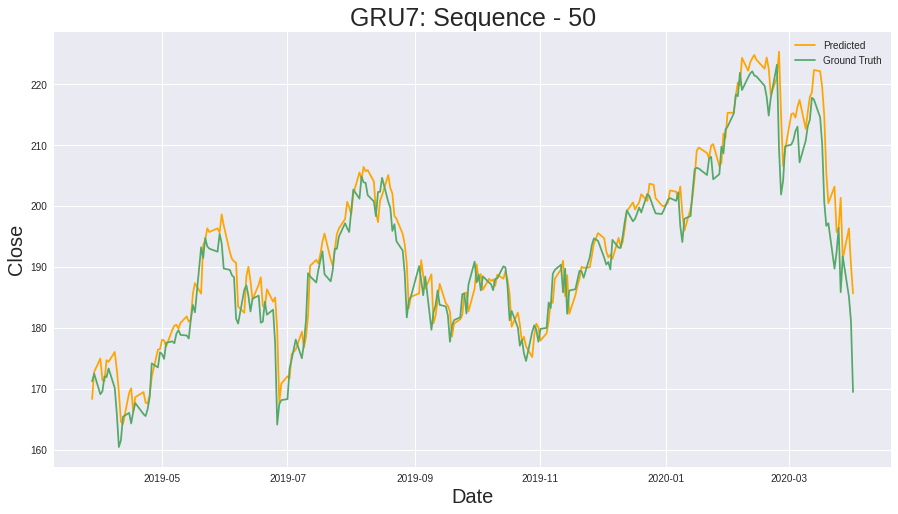

In [121]:
plot_results(gru_7, 'Meta', 'Close', 'GRU7', sequence)

**Using Meta Close Price only**

As rows NaNs were dropped in the Merged dataset I will reuse that dataset by dropping the columns for netflix and twitter

In [122]:
merged_meta = merged.drop(columns=['TWTR_close', 'NFLX_close'], axis=1)

In [123]:
merged_meta.head(5)

,Close
Date,
2013-11-07,47.560001
2013-11-08,47.529999
2013-11-11,46.200001
2013-11-12,46.610001
2013-11-13,48.709999


In [124]:
#will drop meta from the x data
train_loader, val_loader, test_loader, pred_one_loader, scaler, df1, x_train, sequence  = data_sequence(df_meta,'Close', '2013-11-07','2020-06-30',
                                '','', [], 
                                 50, 32, include_target=True, diff_testset=False)

X_train.shape = (916, 49, 6)
y_train.shape = (916, 1)
X_validation.shape = (272, 49, 6)
y_validation.shape = (272, 1)
X_test.shape = (272, 49, 6)
y_test.shape = (272, 1)


In [125]:
gru8 = GRU(in_dims=3,
         hid_dims=512,
         no_layers=1,
         out_dim=1,
         model_name = 'GRU8',
         model_run_no=run_no, 
         drop_prob=0)


history_gru8 = fit(gru8.to(device),
            train_loader,
            val_loader,
            epochs=60,
            lr=.001,
            opt_func='Adam',
            batch_size = 32,
            num_feat=3,
            ROPlateau=False)

Epoch [0], train_loss: 0.0036, val_loss: 0.0043
Epoch [5], train_loss: 0.0065, val_loss: 0.0044
Epoch [10], train_loss: 0.0003, val_loss: 0.0011
Epoch [15], train_loss: 0.0002, val_loss: 0.0011
Epoch [20], train_loss: 0.0002, val_loss: 0.0011
Epoch [25], train_loss: 0.0002, val_loss: 0.0011
Epoch [30], train_loss: 0.0002, val_loss: 0.0012
Epoch [35], train_loss: 0.0002, val_loss: 0.0012
Epoch [40], train_loss: 0.0002, val_loss: 0.0011
Epoch [45], train_loss: 0.0002, val_loss: 0.0011
Epoch [50], train_loss: 0.0002, val_loss: 0.0011
Epoch [55], train_loss: 0.0002, val_loss: 0.0010
Training Duration: 0.34 minutes.


In [126]:
gru_8, loss_gru8 = result(
    gru8,
    scaler,
    sequence,
    gru8.model_name,
    gru8.model_run_no,
    test_loader,
    df1,
    x_train,
    batch_size=32,
    num_feat=3,
    diff_testset=False,
)

Test RMSE: 3.739


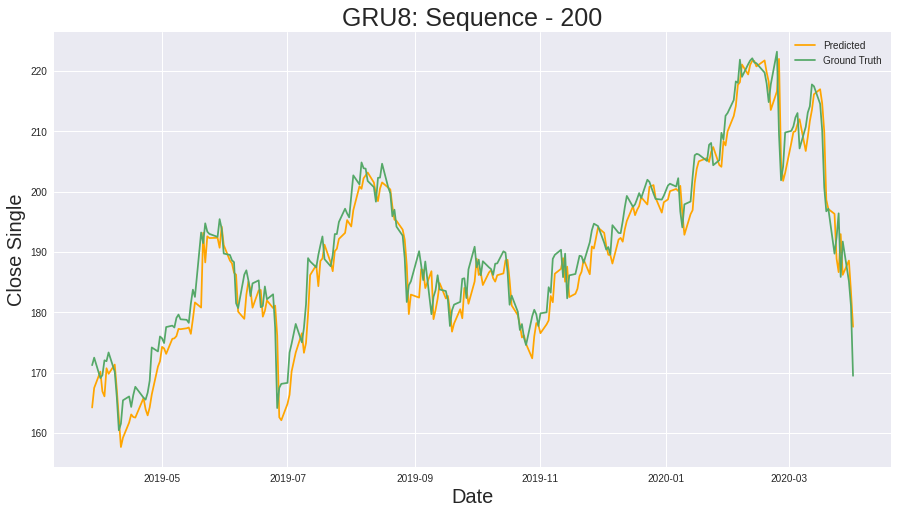

In [132]:
plot_results(gru_8, 'Meta', 'Close Single', 'GRU8', sequence)

## 4.2 Using a combination of stocks features to predict


In [127]:
#this time we want full dataset with multiple features
train_loader, val_loader, test_loader, pred_one_loader, scaler, df1, x_train, sequence  = data_sequence(df_abc,'High', '2010-01-01','2020-06-30',
                                '','', ['Volume','Adj Close'], 
                                 200, 16, include_target=True, diff_testset=False)

X_train.shape = (1347, 199, 4)
y_train.shape = (1347, 1)
X_validation.shape = (316, 199, 4)
y_validation.shape = (316, 1)
X_test.shape = (316, 199, 4)
y_test.shape = (316, 1)


In [128]:
device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

run_no+=1

In [129]:
gru9 = GRU(in_dims=4,
         hid_dims=512,
         no_layers=1,
         out_dim=1,
         model_name = 'GRU9',
         model_run_no=run_no, 
         drop_prob=0)


history_gru9 = fit(gru9.to(device),
            train_loader,
            val_loader,
            epochs=20,
            lr=.0001,
            opt_func='Adam',
            batch_size = 16,
            num_feat=4,
            ROPlateau=False)

Epoch [0], train_loss: 0.0055, val_loss: 0.0027
Epoch [5], train_loss: 0.0010, val_loss: 0.0005
Epoch [10], train_loss: 0.0002, val_loss: 0.0005
Epoch [15], train_loss: 0.0001, val_loss: 0.0004
Training Duration: 0.47 minutes.


In [130]:
gru_9, loss_gru9 = result(
    gru9,
    scaler,
    sequence,
    gru9.model_name,
    gru9.model_run_no,
    test_loader,
    df1,
    x_train,
    batch_size=16,
    num_feat=4,
    diff_testset=False)

Test RMSE: 1.703


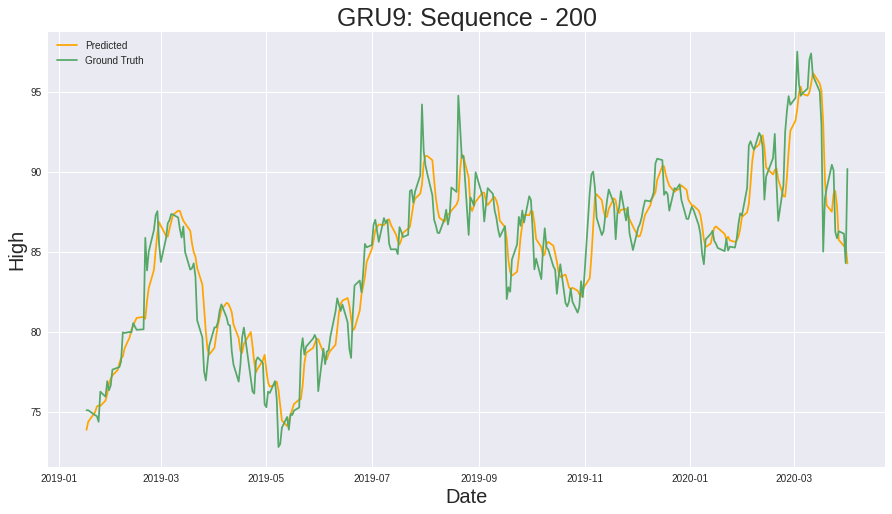

In [131]:
plot_results(gru_9, 'ABC', 'High', 'GRU9', sequence)

**Without extra Features**


In [133]:
#this time we want full dataset with multiple features
train_loader, val_loader, test_loader, pred_one_loader, scaler, df1, x_train, sequence  = data_sequence(df_abc,'High', '2010-01-01','2020-06-30',
                                '','', ['Volume', 'Adj Close', 'Open', 'Close', 'Low'], 
                                 200, 16, include_target=True, diff_testset=False)

X_train.shape = (1347, 199, 1)
y_train.shape = (1347, 1)
X_validation.shape = (316, 199, 1)
y_validation.shape = (316, 1)
X_test.shape = (316, 199, 1)
y_test.shape = (316, 1)


In [134]:
device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

run_no+=1

In [135]:
#change dimensions 
gru10 = GRU(in_dims=1,
         hid_dims=512,
         no_layers=1,
         out_dim=1,
         model_name = 'GRU10',
         model_run_no=run_no, 
         drop_prob=0.0)


history_gru10 = fit(gru10.to(device),
            train_loader,
            val_loader,
            epochs=20,
            lr=.0001,
            opt_func='Adam',
            batch_size = 16,
            num_feat=1,
            ROPlateau=False)

Epoch [0], train_loss: 0.0058, val_loss: 0.0040
Epoch [5], train_loss: 0.0062, val_loss: 0.0017
Epoch [10], train_loss: 0.0011, val_loss: 0.0007
Epoch [15], train_loss: 0.0014, val_loss: 0.0009
Training Duration: 0.46 minutes.


In [136]:
gru_10, loss_gru10 = result(
    gru10,
    scaler,
    sequence,
    gru10.model_name,
    gru10.model_run_no,
    test_loader,
    df1,
    x_train,
    batch_size=16,
    num_feat=1,
    diff_testset=False)

Test RMSE: 4.065


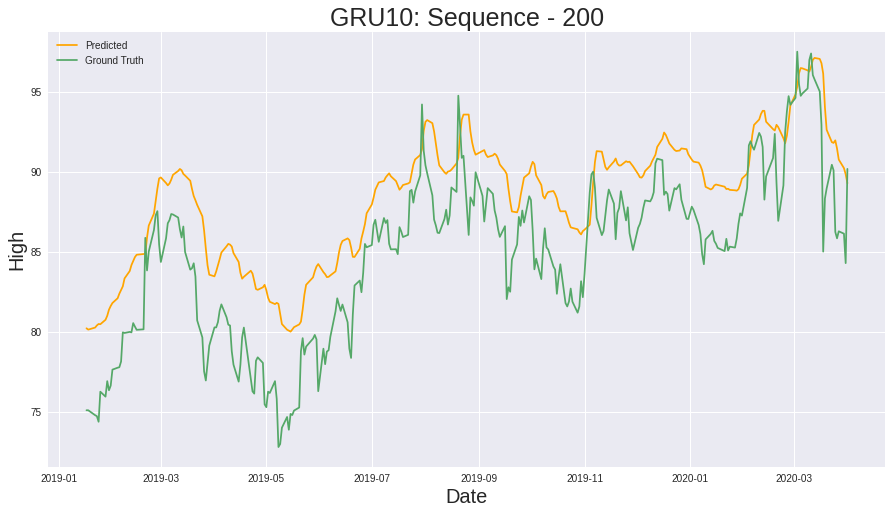

In [137]:
plot_results(gru_10, 'ABC', 'High', 'GRU10', sequence)

Okay so adding more input dimensions from the same stocks seems to improve the models ability to forecast.

# Section 5 - Fail Cases

We will assess our GRU model with multiple features with different layers, dropout and optimisation to have probles that were a common theme throughout the task. 

In [138]:
#this time we want full dataset with multiple features
train_loader, val_loader, test_loader, pred_one_loader, scaler, df1, x_train, sequence  = data_sequence(df_abc,'High', '2010-01-01','2020-06-30',
                                '','', ['Volume','Adj Close'], 
                                 200, 16, include_target=True, diff_testset=False)

X_train.shape = (1347, 199, 4)
y_train.shape = (1347, 1)
X_validation.shape = (316, 199, 4)
y_validation.shape = (316, 1)
X_test.shape = (316, 199, 4)
y_test.shape = (316, 1)


In [139]:
device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

run_no = 1

In [140]:
gru11 = GRU(in_dims=4,
         hid_dims=512,
         no_layers=3,
         out_dim=1,
         model_name = 'GRU9',
         model_run_no=run_no, 
         drop_prob=.5)


history_gru11 = fit(gru11.to(device),
            train_loader,
            val_loader,
            epochs=20,
            lr=.0001,
            opt_func='Adam',
            batch_size = 16,
            num_feat=4,
            ROPlateau=False)

Epoch [0], train_loss: 0.0025, val_loss: 0.0118
Epoch [5], train_loss: 0.0021, val_loss: 0.0010
Epoch [10], train_loss: 0.0007, val_loss: 0.0012
Epoch [15], train_loss: 0.0006, val_loss: 0.0012
Training Duration: 1.43 minutes.


In [141]:
gru_11, loss_gru11 = result(
    gru11,
    scaler,
    sequence,
    gru11.model_name,
    gru11.model_run_no,
    test_loader,
    df1,
    x_train,
    batch_size=16,
    num_feat=4,
    diff_testset=False)

Test RMSE: 4.913


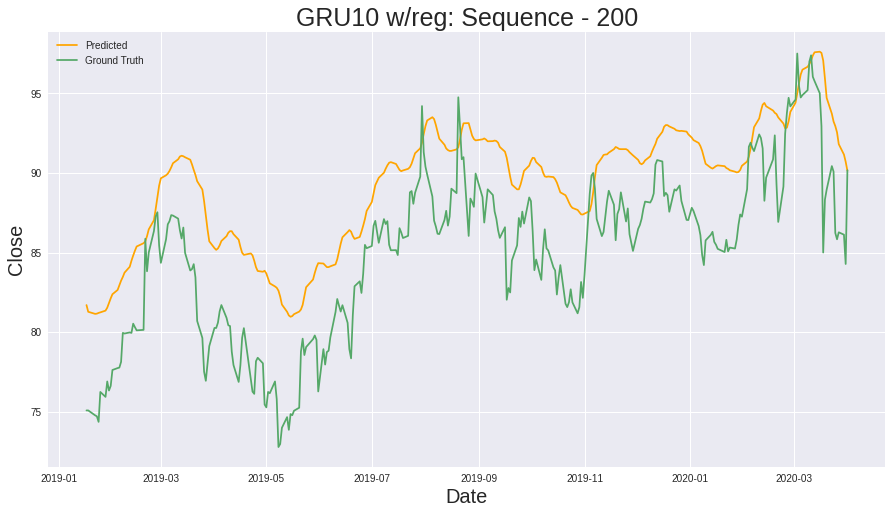

In [142]:
plot_results(gru_11, 'ABC', 'Close', 'GRU10 w/reg', sequence)

This result is indicative of many results seen during the exploration of these models. The vast majority of implementations were initially explored with layers ranging from 2-5 with differing dropout probabilities. In each case, the extra layers were more likely to overpower the regularisation and overfit leading to worst testing performance. Exploring further regularisation techniques will be necessary for future undertakings. 

Another interesting thing that occured was the poor performances of other optimisers. SGD, in particular struggled to handle these datasets, and were implemented in various iterations. I left these out of the final notebook to reduce the clutter.